In [1]:
import numpy as np 
import pandas as pd
import os

C:\Users\ASUS\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
import matplotlib.pyplot as plt
import random

In [3]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import MeanSquaredError
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dropout
from tensorflow.keras.preprocessing import image

In [4]:
base_model = ResNet50(weights='imagenet', include_top=False)

In [5]:
labels_df = pd.read_csv('train_v2.csv')

In [59]:
labels_df.head()

,image_name,tags,deforestation
0,train_0,haze primary,0.0
1,train_1,agriculture clear primary water,0.0
2,train_2,clear primary,0.0
3,train_3,clear primary,0.0
4,train_4,agriculture clear habitation primary road,0.0


In [6]:
def extract_numerical_value(tag):
    try:
        return float(tag.split("_")[1])
    except (IndexError, ValueError):
        return np.nan

labels_df['deforestation'] = labels_df['tags'].apply(extract_numerical_value)

labels_df = labels_df.dropna(subset=['deforestation'])

In [7]:
if 'tags' not in labels_df.columns:
    raise ValueError("'tags' column is missing from the dataset.")

print(labels_df['tags'].head()) 
print(labels_df['tags'].unique())

Series([], Name: tags, dtype: object)
[]


In [8]:
try:
    labels_df = pd.read_csv('train_v2.csv')
    print(f"Loaded dataset with shape: {labels_df.shape}")
except FileNotFoundError:
    raise ValueError("The file 'train_v2.csv' was not found. Check the file path.")

if 'tags' not in labels_df.columns:
    raise ValueError("'tags' column is missing from the dataset.")

def extract_deforestation(tag):
    try:
        if "_" in tag:
            return float(tag.split("_")[1])
        else:
            return 0.0
    except (IndexError, ValueError):
        return np.nan

labels_df['deforestation'] = labels_df['tags'].apply(extract_deforestation)

labels_df = labels_df.dropna(subset=['deforestation'])
if labels_df.empty:
    raise ValueError("No valid data available after preprocessing. Check the 'tags' column format.")

train_df, val_df = train_test_split(labels_df, test_size=0.2, random_state=42)
print(f"Train samples: {len(train_df)}, Validation samples: {len(val_df)}")

Loaded dataset with shape: (40479, 2)
Train samples: 25242, Validation samples: 6311


In [9]:
train_df['image_name'] = train_df['image_name'].apply(lambda x: f"{x}.jpg")
val_df['image_name'] = val_df['image_name'].apply(lambda x: f"{x}.jpg")

In [10]:
def create_dataset_generator(df, data_dir, batch_size=32, target_size=(224, 224)):
    datagen = ImageDataGenerator(rescale=1./255)
    generator = datagen.flow_from_dataframe(
        df, directory=data_dir, x_col='image_name', y_col=['deforestation'],
        target_size=target_size, batch_size=batch_size, class_mode='raw')
    return generator

In [11]:
data_dir = 'D:/DOWNLOADS/train-jpg/train-jpg'
train_generator = create_dataset_generator(train_df, data_dir)
val_generator = create_dataset_generator(val_df, data_dir)

Found 25242 validated image filenames.
Found 6311 validated image filenames.


In [12]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(2048, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='linear')(x)

In [13]:
model = Model(inputs=base_model.input, outputs=predictions)

In [14]:
for layer in base_model.layers:
    layer.trainable = False

In [15]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=[MeanSquaredError(name='mse')])

In [16]:
history = model.fit(train_generator, epochs=5, validation_data=val_generator)

Epoch 1/5


C:\Users\ASUS\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


789/789 ━━━━━━━━━━━━━━━━━━━━ 697s 877ms/step - loss: 0.9912 - mse: 0.9913 - val_loss: 6.9542e-07 - val_mse: 6.9653e-07
Epoch 2/5
789/789 ━━━━━━━━━━━━━━━━━━━━ 689s 873ms/step - loss: 4.8306e-07 - mse: 4.8306e-07 - val_loss: 1.0325e-06 - val_mse: 1.0347e-06
Epoch 3/5
789/789 ━━━━━━━━━━━━━━━━━━━━ 700s 887ms/step - loss: 8.4971e-05 - mse: 8.4993e-05 - val_loss: 2.9590e-07 - val_mse: 2.9631e-07
Epoch 4/5
789/789 ━━━━━━━━━━━━━━━━━━━━ 690s 874ms/step - loss: 4.4079e-07 - mse: 4.4081e-07 - val_loss: 0.0060 - val_mse: 0.0060
Epoch 5/5
789/789 ━━━━━━━━━━━━━━━━━━━━ 702s 889ms/step - loss: 8.4585e-04 - mse: 8.4587e-04 - val_loss: 7.5738e-08 - val_mse: 7.5775e-08


In [55]:
def predict_deforestation(model, img_path, img_size=(224, 224)):
    img = image.load_img(img_path, target_size=img_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = x / 255.0
    preds = model.predict(x)
    return preds

In [56]:
def display_image_with_predictions(img_path, deforestation_value):
    img = image.load_img(img_path)
    plt.figure()
    plt.imshow(img)
    plt.title(f"Deforestation Value: {deforestation_value:.4f}")
    plt.axis("off")
    plt.show()

In [57]:
test_data_dir = 'D:/DOWNLOADS/test-jpg/test-jpg'
test_images = random.sample(os.listdir(test_data_dir), 1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


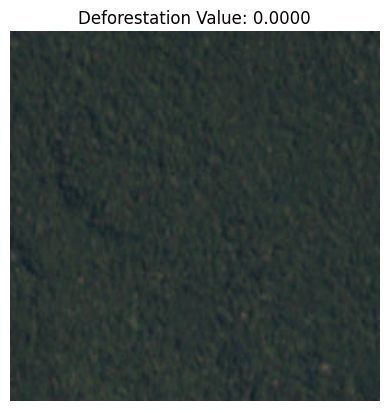

In [58]:
for img_name in test_images:
    img_path = os.path.join(test_data_dir, img_name)
    preds = predict_deforestation(model, img_path)
    deforestation_value = preds[0][0]
    display_image_with_predictions(img_path, deforestation_value)